# United Kingdom Crime Classification - Multi Layer Perceptron Classifier with Data Chunking methodology
# Classifying **Crime type** using TensorFlow/Keras via Longtitude/Latitude and Police Force, using Pattern Recognition

In [1]:
# Purpose: import core libraries for data processing, modeling, and plotting
# Libraries

# %%
import psutil
import matplotlib.pyplot as plt
from collections import deque
import time
import os
import io
import requests
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm  # use console tqdm to avoid ipywidgets warning
import math


from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, recall_score, confusion_matrix, roc_auc_score, accuracy_score
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Reduce TensorFlow log verbosity (set before importing TF)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D, Flatten, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
from tensorflow.keras.regularizers import l2
import seaborn as sns

2025-12-20 03:51:02.557636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-20 03:51:02.581857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-20 03:51:02.581927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Class Declaration

In [2]:
# Purpose: helper to visualize training curves and save figures
def plot_training_history(history, save_path="Model"):
    os.makedirs(save_path, exist_ok=True)

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "training_curves.png"), dpi=300)
    plt.show()


## GPU Acceleration Pre-Training Hardware Verification

In [3]:
# Purpose: verify GPU availability and enable optional accelerations
# GPU Configuration (safe defaults)
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# --- Toggles (use these if your GPU/driver supports them) ---
USE_MIXED_PRECISION = True   # set True for faster training on supported GPUs
USE_XLA = True      # set True to enable XLA (jit_compile) - can cause "illegal access" on some setups

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU(s) configured: {[gpu.name for gpu in gpus]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, running on CPU")
    # Auto-disable accelerations not helpful on CPU-only runs
    USE_MIXED_PRECISION = False
    USE_XLA = False

# Mixed precision (optional)
if USE_MIXED_PRECISION:
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled: mixed_float16")
else:
    mixed_precision.set_global_policy('float32')
    print("Mixed precision disabled: float32")


TensorFlow version: 2.16.2
Num GPUs Available:  1
GPU(s) configured: ['/physical_device:GPU:0']
Mixed precision enabled: mixed_float16


## Load Dataset

The raw CSV is large, so we prepare it for streaming by converting it to HDF5.


In [4]:
# Purpose: define preprocessing inputs, columns, and chunking controls
# Step 1: Memory-Efficient Data Preprocessing (Chunked CSV → HDF5)
# Dataset folder lives alongside the MLP project (sibling of this notebook), not inside it.
input_csv = "../Dataset/mergedCRDataset.csv"
preprocessed_hdf5_file = "../Dataset/Preprocessed/MergedCRDataset.h5"
os.makedirs(os.path.dirname(preprocessed_hdf5_file), exist_ok=True)

chunksize = 1_000_000
chunk_idx = 0

numeric_cols = ['Longitude', 'Latitude']
categorical_cols = ['Reported by', 'Falls within']
target_col = 'Crime type'
group_col = 'LSOA name'

# display top 5 values of the dataset


# Class Defnition and Instantiation

In [5]:
# Purpose: encapsulate chunked CSV -> HDF5 preprocessing with encoders
class Preprocessor:

    def __init__(
        self,
        input_csv: str,
        hdf5_path: str,
        encoders_path: str,
        numeric_cols: list,
        categorical_cols: list,
        target_col: str,
        drop_cols: list,
        sep: str = "\t",
        chunksize: int = 1_000_000,
        on_bad_lines: str = "skip",
        engine: str = "python",
        verbose: bool = True,
    ):
        # Store IO configuration
        self.input_csv = input_csv
        self.hdf5_path = hdf5_path
        self.encoders_path = encoders_path
        # Store column roles for preprocessing
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols
        self.target_col = target_col
        self.drop_cols = drop_cols
        # CSV parsing controls
        self.sep = sep
        self.chunksize = chunksize
        self.on_bad_lines = on_bad_lines
        self.engine = engine
        self.verbose = verbose

        # Encoding maps (fit-on-the-fly as chunks stream in)
        self.cat_maps = {c: {} for c in self.categorical_cols}
        self.target_map = {}

    def _ensure_dirs(self):
        # Create output folders if missing
        os.makedirs(os.path.dirname(self.hdf5_path), exist_ok=True)
        os.makedirs(os.path.dirname(self.encoders_path), exist_ok=True)

    def _read_chunks(self):
        # Stream CSV in chunks to avoid full RAM load
        return pd.read_csv(
            self.input_csv,
            sep=self.sep,
            engine=self.engine,
            on_bad_lines=self.on_bad_lines,
            chunksize=self.chunksize,
        )

    def _clean_chunk(self, chunk: pd.DataFrame, chunk_idx: int):
        # Normalize column names and remove duplicates
        chunk.columns = chunk.columns.str.strip()
        chunk.drop_duplicates(inplace=True)
        # Drop ID-style columns that do not help prediction
        chunk.drop(columns=self.drop_cols, inplace=True, errors="ignore")

        # Skip chunks missing the target
        if self.target_col not in chunk.columns:
            if self.verbose:
                print(
                    f"[!] Chunk {chunk_idx}: target column '{self.target_col}' not found. Skipping chunk."
                )
            return None

        # Remove rows without a target label
        chunk = chunk.dropna(subset=[self.target_col])
        # Keep only the intended columns
        keep_cols = [
            c
            for c in (self.numeric_cols + self.categorical_cols + [self.target_col])
            if c in chunk.columns
        ]
        return chunk[keep_cols].copy()

    def _impute_and_fill(self, chunk: pd.DataFrame) -> pd.DataFrame:
        # Numeric: median imputation is robust to outliers
        for col in self.numeric_cols:
            if col in chunk.columns:
                med = chunk[col].median()
                chunk[col] = chunk[col].fillna(med)
        # Categorical: fill missing with a sentinel token
        for col in self.categorical_cols:
            if col in chunk.columns:
                chunk[col] = chunk[col].astype("string").fillna("Unknown")
        return chunk

    def _summarize(self, chunk: pd.DataFrame, chunk_idx: int):
        # Quick per-chunk missingness summary for monitoring
        summary = pd.DataFrame({
            "missing": chunk.isna().sum(),
            "non_missing": chunk.notna().sum(),
            "total": len(chunk),
        })
        print(f"Chunk {chunk_idx} summary:")
        print(summary)

    def _encode_series(self, s: pd.Series, mapping: dict) -> np.ndarray:
        # Convert strings to stable integer IDs
        s = s.astype("string").fillna("Unknown")
        out = np.empty(len(s), dtype=np.int32)

        mapped = s.map(mapping)
        unseen_mask = mapped.isna()

        # Extend mapping for new categories encountered in later chunks
        if unseen_mask.any():
            unseen_vals = s[unseen_mask].unique().tolist()
            start = len(mapping)
            for i, v in enumerate(unseen_vals):
                mapping[str(v)] = start + i
            mapped = s.map(mapping)

        out[:] = mapped.astype(np.int32).to_numpy()
        return out

    def _features_matrix(self, chunk: pd.DataFrame, n_features: int) -> np.ndarray:
        # Assemble feature matrix in a fixed column order
        X_parts = []
        for col in self.numeric_cols:
            if col in chunk.columns:
                X_parts.append(chunk[col].to_numpy(dtype=np.float32))
            else:
                X_parts.append(np.zeros(len(chunk), dtype=np.float32))
        for col in self.categorical_cols:
            if col in chunk.columns:
                enc = self._encode_series(chunk[col], self.cat_maps[col]).astype(np.float32)
                X_parts.append(enc)
            else:
                X_parts.append(np.zeros(len(chunk), dtype=np.float32))
        return np.stack(X_parts, axis=1).astype(np.float32)

    def _append_to_hdf5(self, X_ds, y_ds, X_chunk: np.ndarray, y_enc: np.ndarray, total_rows: int) -> int:
        # Grow datasets and write the next block
        new_total = total_rows + len(X_chunk)
        X_ds.resize((new_total, X_ds.shape[1]))
        y_ds.resize((new_total,))
        X_ds[total_rows:new_total, :] = X_chunk
        y_ds[total_rows:new_total] = y_enc
        return new_total

    def _preprocessed_exists(self) -> bool:
        # Skip preprocessing if cached HDF5 already exists
        exists = os.path.exists(self.hdf5_path)
        if exists and self.verbose:
            print(f"✓ Preprocessed data already exists at {self.hdf5_path}")
            print("Skipping preprocessing... Loading from file.")
        return exists

    def _init_datasets(self, h5_handle, n_features: int):
        # Create extensible datasets for streaming writes
        X_ds = h5_handle.create_dataset(
            "X",
            shape=(0, n_features),
            maxshape=(None, n_features),
            dtype="float32",
            chunks=True,
        )
        y_ds = h5_handle.create_dataset(
            "y",
            shape=(0,),
            maxshape=(None,),
            dtype="int32",
            chunks=True,
        )
        return X_ds, y_ds

    def _process_chunk(self, chunk_idx: int, chunk: pd.DataFrame, X_ds, y_ds, total_rows: int, n_features: int) -> int:
        # Clean + prepare a single chunk before writing
        cleaned = self._clean_chunk(chunk, chunk_idx)
        if cleaned is None:
            return total_rows

        prepared = self._impute_and_fill(cleaned)

        if self.verbose:
            self._summarize(prepared, chunk_idx)

        X_chunk = self._features_matrix(prepared, n_features)
        y_enc = self._encode_series(prepared[self.target_col], self.target_map)

        total_rows = self._append_to_hdf5(X_ds, y_ds, X_chunk, y_enc, total_rows)

        if self.verbose:
            print(f"Chunk {chunk_idx} target value counts (top 10):")
            print(prepared[self.target_col].value_counts().head(10))
            print(f"[✓] Appended {len(prepared):,} rows. Total so far: {total_rows:,}")

        return total_rows

    def preprocess(self):
        # Top-level entry point for chunked preprocessing
        self._ensure_dirs()

        n_features = len(self.numeric_cols) + len(self.categorical_cols)

        if self._preprocessed_exists():
            return

        if self.verbose:
            print(f"Preprocessing dataset and saving to {self.hdf5_path}...")

        with h5py.File(self.hdf5_path, "w") as h5:
            X_ds, y_ds = self._init_datasets(h5, n_features)

            total_rows = 0
            for chunk_idx, chunk in enumerate(self._read_chunks(), start=1):
                total_rows = self._process_chunk(chunk_idx, chunk, X_ds, y_ds, total_rows, n_features)

            if self.verbose:
                print(f"Total number of samples saved: {total_rows:,}")

        # Save all encoder mappings for consistent inference later
        encoders = {
            "categorical_maps": self.cat_maps,
            "target_map": self.target_map,
            "numeric_cols": self.numeric_cols,
            "categorical_cols": self.categorical_cols,
            "target_col": self.target_col,
            "drop_cols": self.drop_cols,
        }
        with open(self.encoders_path, "wb") as f:
            pickle.dump(encoders, f)

        if self.verbose:
            print(f"✓ Preprocessing complete! Data saved to HDF5.")
            print(f"✓ Encoder mappings saved to: {self.encoders_path}")


class TrainingConfig:
    def __init__(self, learning_rate=1e-4, epochs=25, batch_size=256, l2_reg_dense1=5e-4, l2_reg_dense2=1e-4):
        # Centralized hyperparameters for reproducibility
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.l2_reg_dense1 = l2_reg_dense1
        self.l2_reg_dense2 = l2_reg_dense2


class CallbacksManager:
    @staticmethod
    def build_default_callbacks(early_stop_patience=5, lr_reduce_patience=3, min_lr=1e-6):
        # Standard callbacks for convergence control
        return [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=early_stop_patience,
                restore_best_weights=True,
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=lr_reduce_patience,
                min_lr=min_lr,
            ),
        ]


class MultiLayerPerceptron:
    def __init__(self, n_features: int, num_classes: int, config: TrainingConfig = None):
        # Model wrapper for build/compile/train/eval
        self.n_features = n_features
        self.num_classes = num_classes
        self.config = config or TrainingConfig()
        self.model = None
        self.history = None

        self._build()
        self._compile()

    def _build(self):
        # Define the dense MLP architecture
        self.model = Sequential([
            Input(shape=(self.n_features,)),
            Dense(128, activation="relu", kernel_regularizer=l2(self.config.l2_reg_dense1)),
            Dense(64, activation="relu", kernel_regularizer=l2(self.config.l2_reg_dense2)),
            Dense(self.num_classes, activation="softmax"),
        ])
        print(f"✓ Model architecture built: {self.n_features} features → {self.num_classes} classes")

    def _compile(self):
        # Compile with multiclass loss + accuracy metric
        self.model.compile(
            optimizer=Adam(learning_rate=self.config.learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        print(f"✓ Model compiled (lr={self.config.learning_rate}, loss=sparse_categorical_crossentropy)")

    def summary(self):
        return self.model.summary()

    def train(self, train_ds, val_ds, class_weight_dict=None, callbacks=None, verbose=2, epochs=None, steps_per_epoch=None, validation_steps=None):
        # Train using streamed datasets and optional class weights
        if callbacks is None:
            callbacks = CallbacksManager.build_default_callbacks()

        print("" + "=" * 80)
        print("STARTING TRAINING")
        print("=" * 80)
        print(f"Learning Rate: {self.config.learning_rate}")
        print(f"Epochs: {epochs or self.config.epochs}")
        print(f"L2 Regularization Dense1: {self.config.l2_reg_dense1}")
        print(f"L2 Regularization Dense2: {self.config.l2_reg_dense2}")
        print("=" * 80 + "")

        self.history = self.model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs or self.config.epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=verbose,
        )

        print("" + "=" * 80)
        print("TRAINING COMPLETE")
        print("=" * 80)

        return self.history

    def predict_proba(self, data):
        # Return probability distribution over classes
        return self.model.predict(data, verbose=0)

    def predict_classes(self, data):
        # Convert probabilities to class indices
        probs = self.predict_proba(data)
        return np.argmax(probs, axis=1)

    def evaluate(self, test_ds, verbose=1):
        # Evaluate model on a dataset
        return self.model.evaluate(test_ds, verbose=verbose)

    def save(self, model_dir="Model"):
        # Save model weights + training config for reuse
        os.makedirs(model_dir, exist_ok=True)
        model_path = os.path.join(model_dir, "mlp_model.keras")
        self.model.save(model_path)
        with open(os.path.join(model_dir, "training_config.pkl"), "wb") as f:
            pickle.dump(self.config, f)
        print(f"✓ Model saved to {model_path}")


def load_model(model_path: str, n_features: int, num_classes: int, config: TrainingConfig = None):
    # Rebuild architecture then load weights for inference
    mlp = MultiLayerPerceptron(n_features, num_classes, config)
    mlp.model = tf.keras.models.load_model(model_path)
    print(f"✓ Loaded model from {model_path}")
    return mlp

## Data Preprocessing

This pipeline is designed to scale to large CSVs without exhausting RAM while keeping preprocessing reproducible:

- Read the raw CSV in chunks and stream rows into an HDF5 file (no full in-memory load).
- Drop unused identifier columns to reduce leakage risk and storage.
- Impute missing numeric values with a robust statistic (median).
- Standardize categorical handling by filling missing with a sentinel (e.g., "Unknown").
- Encode categorical features and the target label with stable integer maps.
- Persist encoders so training and inference use identical mappings.




In [6]:
# Purpose: run preprocessing once and persist HDF5 + encoders
# Step 1: Memory-Efficient Data Preprocessing (Chunked CSV → HDF5)
# Only preprocess if file doesn't already exist

drop_columns = [
    "Crime ID"
]

# Store encoder mappings alongside the HDF5 file
encoders_path = os.path.join(os.path.dirname(preprocessed_hdf5_file), "encoders.pkl")

preprocessor = Preprocessor(
    input_csv=input_csv,
    hdf5_path=preprocessed_hdf5_file,
    encoders_path=encoders_path,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    target_col=target_col,
    drop_cols=drop_columns,
    sep=",",  # CSV separator
    chunksize=chunksize,
    on_bad_lines="skip",
    engine="python",
    verbose=True,
)

# Run preprocessing (no-op if cached)
preprocessor.preprocess()


✓ Preprocessed data already exists at ../Dataset/Preprocessed/MergedCRDataset.h5
Skipping preprocessing... Loading from file.


## Streaming Training Pipeline Configuration

We keep memory usage bounded by streaming batches from disk via HDF5 and tf.data.
Key ideas:
- Split by indices only (no copying arrays into RAM).
- Read batches on demand from HDF5.
- Use class weights to reduce imbalance bias.


In [7]:
# Purpose: set streaming training configuration and report it
# 1️⃣ Configuration - LOCK THIS IN FOR MSc SUBMISSION

HDF5_PATH = preprocessed_hdf5_file  # "Dataset/Preprocessed/london_crime_data.h5"
BATCH_SIZE = 256          # SAFE for 16GB RAM + GTX 2060
EPOCHS = 25
SHUFFLE_BUFFER = 10_000   # Safe shuffling without RAM blowup

print("=" * 80)
print("STREAMING TRAINING CONFIGURATION")
print("=" * 80)
print(f"HDF5 Path: {HDF5_PATH}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Shuffle Buffer: {SHUFFLE_BUFFER:,}")
print("=" * 80)

STREAMING TRAINING CONFIGURATION
HDF5 Path: ../Dataset/Preprocessed/MergedCRDataset.h5
Batch Size: 256
Epochs: 25
Shuffle Buffer: 10,000


In [8]:
# Purpose: read dataset shape from HDF5 without loading samples
# 2️⃣ Get dataset shape (cheap, NO RAM hit)

with h5py.File(HDF5_PATH, "r") as f:
    N_SAMPLES = f["X"].shape[0]
    N_FEATURES = f["X"].shape[1]

print(f"Total Samples: {N_SAMPLES:,}")
print(f"Features: {N_FEATURES}")

Total Samples: 30,726,475
Features: 4


## Train/Test Split

In [9]:
# Purpose: create train/validation index split for streaming
# 3️⃣ Train / Validation split (indices only - NO data copying)

indices = np.arange(N_SAMPLES)
np.random.seed(42)
np.random.shuffle(indices)

split = int(0.8 * N_SAMPLES)
train_idx = indices[:split]
val_idx = indices[split:]

print(f"Training samples: {len(train_idx):,}")
print(f"Validation samples: {len(val_idx):,}")

Training samples: 24,581,180
Validation samples: 6,145,295


In [10]:
# Purpose: sanitize labels, rebuild splits, and recompute class weights to avoid invalid labels
# 3️⃣b Label validation + safe train/val split
with h5py.File(HDF5_PATH, "r") as f:
    y_all = f["y"][:]

invalid_mask = y_all < 0
invalid_count = int(invalid_mask.sum())
if invalid_count:
    print(f"[WARN] Found {invalid_count} invalid labels (<0). Excluding them from training/validation splits.")
else:
    print("✓ No invalid labels found in y.")

valid_indices = np.where(~invalid_mask)[0]

np.random.seed(42)
np.random.shuffle(valid_indices)
split = int(0.8 * len(valid_indices))
train_idx = valid_indices[:split]
val_idx = valid_indices[split:]

classes = np.unique(y_all[~invalid_mask])
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_all[~invalid_mask],
)
class_weight_dict = dict(zip(classes, weights))

print(f"Training samples: {len(train_idx):,}")
print(f"Validation samples: {len(val_idx):,}")
print(f"Classes: {len(classes)}; label range: {classes.min()}..{classes.max()}")

[WARN] Found 13572590 invalid labels (<0). Excluding them from training/validation splits.
Training samples: 13,723,108
Validation samples: 3,430,777
Classes: 14; label range: 0..13


In [11]:
# Purpose: generator yields HDF5 batches on demand
# 4️⃣ HDF5 Batch Generator (core streaming fix)

def hdf5_batch_generator(h5_path, indices, batch_size):
    """
    Generator that reads batches from HDF5 on-demand. Ensures ascending indices per batch
    to satisfy h5py's fancy indexing requirement, then restores original order.
    """
    import h5py
    import numpy as np

    with h5py.File(h5_path, "r") as f:
        X = f["X"]
        y = f["y"]

        # Iterate through index slices to keep memory bounded
        for i in range(0, len(indices), batch_size):
            batch_idx = np.array(indices[i:i + batch_size], dtype=np.int64)
            if batch_idx.size == 0:
                continue

            # h5py needs ascending order for fancy indexing; remember the original order
            order = np.argsort(batch_idx)
            sorted_idx = batch_idx[order]
            X_batch = X[sorted_idx]
            y_batch = y[sorted_idx]

            # Restore original ordering inside the batch
            inv_order = np.argsort(order)
            yield X_batch[inv_order], y_batch[inv_order]

In [12]:
# Purpose: build tf.data pipelines from the streaming generator
# 5️⃣ Build tf.data datasets (streamed)

train_ds = tf.data.Dataset.from_generator(
    lambda: hdf5_batch_generator(HDF5_PATH, train_idx, BATCH_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(None, N_FEATURES), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: hdf5_batch_generator(HDF5_PATH, val_idx, BATCH_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(None, N_FEATURES), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
)


In [13]:
# Purpose: report class weights prepared after label sanitization
# 6️⃣ Class weights (already computed on valid labels)
print("Class weights ready.")
print(f"Total classes: {len(classes)}")
print("Sample weights (first 5):", dict(list(class_weight_dict.items())[:5]))

Class weights ready.
Total classes: 14
Sample weights (first 5): {0: 0.622124910637399, 1: 6.945348237414762, 2: 1.7007821826156964, 3: 0.8890657346046875, 4: 2.2468880771360773}


In [14]:
# Purpose: configure and instantiate the MLP model
# 7️⃣ Model Definition (OOP Version)

training_config = TrainingConfig(
    learning_rate=1e-4,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    l2_reg_dense1=5e-4,
    l2_reg_dense2=1e-4
)

# Build MLP using number of features and classes
model = MultiLayerPerceptron(
    n_features=N_FEATURES,
    num_classes=len(classes),
    config=training_config
)

# Print model architecture for verification
model.summary()

save_path = 'Model'
os.makedirs(save_path, exist_ok=True)

✓ Model architecture built: 4 features → 14 classes
✓ Model compiled (lr=0.0001, loss=sparse_categorical_crossentropy)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,806 (38.30 KB)

 Trainable params: 9,806 (38.30 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Purpose: configure training callbacks (early stop, LR schedule)
# 8️⃣ Callbacks (OOP Version)

callbacks = CallbacksManager.build_default_callbacks(
    early_stop_patience=5,
    lr_reduce_patience=3,
    min_lr=1e-6
)

print("✓ Callbacks configured:")
print("  - Early stopping (patience=5)")
print("  - Learning rate reduction (patience=3)")


✓ Callbacks configured:
  - Early stopping (patience=5)
  - Learning rate reduction (patience=3)


## Training

In [16]:
print("=" * 80)
print("TRAINING ON FULL DATASET - STREAMING FROM DISK")
print("=" * 80)
print(f"Total samples: {N_SAMPLES:,}")
print(f"Training samples: {len(train_idx):,}")
print(f"Validation samples: {len(val_idx):,}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

# Compute steps for clear Keras progress (single fit call)
TRAIN_STEPS = math.ceil(len(train_idx) / BATCH_SIZE)
VAL_STEPS = math.ceil(len(val_idx) / BATCH_SIZE)
print(f"Steps per epoch (train): {TRAIN_STEPS}")
print(f"Validation steps: {VAL_STEPS}")
print("=" * 80)

# Single fit with Keras native progress bar
history = model.train(
    train_ds=train_ds,
    val_ds=val_ds,
    class_weight_dict=class_weight_dict,
    callbacks=callbacks,
    verbose=1,
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_STEPS,
    validation_steps=VAL_STEPS,
)

TRAINING ON FULL DATASET - STREAMING FROM DISK
Total samples: 30,726,475
Training samples: 13,723,108
Validation samples: 3,430,777
Batch size: 256
Epochs: 25
Steps per epoch (train): 53606
Validation steps: 13402
STARTING TRAINING
Learning Rate: 0.0001
Epochs: 25
L2 Regularization Dense1: 0.0005
L2 Regularization Dense2: 0.0001
Epoch 1/25


I0000 00:00:1766202671.227838  153017 service.cc:145] XLA service 0x7800280042d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766202671.227897  153017 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
I0000 00:00:1766202672.949405  153079 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_123', 16 bytes spill stores, 16 bytes spill loads



   40/53606 ━━━━━━━━━━━━━━━━━━━━ 3:37 4ms/step - accuracy: 0.3537 - loss: nan 

I0000 00:00:1766202674.215299  153017 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52557/53606 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3620 - loss: nan 

I0000 00:00:1766202914.256411  153658 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_485', 8 bytes spill stores, 8 bytes spill loads



53606/53606 ━━━━━━━━━━━━━━━━━━━━ 307s 6ms/step - accuracy: 0.3620 - loss: nan - val_accuracy: 0.3621 - val_loss: nan - learning_rate: 1.0000e-04
Epoch 2/25


/home/ybenj/mlenv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53606/53606 ━━━━━━━━━━━━━━━━━━━━ 60s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3621 - val_loss: nan - learning_rate: 1.0000e-04
Epoch 3/25
53606/53606 ━━━━━━━━━━━━━━━━━━━━ 296s 6ms/step - accuracy: 0.3620 - loss: nan - val_accuracy: 0.3621 - val_loss: nan - learning_rate: 1.0000e-04
Epoch 4/25
53606/53606 ━━━━━━━━━━━━━━━━━━━━ 57s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3621 - val_loss: nan - learning_rate: 1.0000e-04
Epoch 5/25
53606/53606 ━━━━━━━━━━━━━━━━━━━━ 291s 5ms/step - accuracy: 0.3620 - loss: nan - val_accuracy: 0.3621 - val_loss: nan - learning_rate: 5.0000e-05
Epoch 6/25
53606/53606 ━━━━━━━━━━━━━━━━━━━━ 58s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3621 - val_loss: nan - learning_rate: 5.0000e-05
TRAINING COMPLETE


In [17]:
# Purpose: save trained model artifacts to disk
# 🔟 Save Model (OOP Version)

model.save(model_dir=save_path)


✓ Model saved to Model/mlp_model.keras


## Evaluation Overview

Predictions are generated in a streaming manner to avoid materializing the full
validation set in memory. We compute both aggregate metrics (accuracy, F1, AUROC)
and per-class diagnostics (confusion matrices, recall bars, ROC curves) to
highlight class imbalance effects.


In [18]:
# Purpose: stream predictions for evaluation without full RAM load
# --- Generate Predictions for Evaluation (Streaming Approach) ---

print("Generating predictions on validation set (streaming)...")

# Collect predictions in batches to keep memory bounded
all_probs = []
all_true = []

# Stream validation batches from disk instead of loading everything at once
for X_batch, y_batch in hdf5_batch_generator(HDF5_PATH, val_idx, BATCH_SIZE):
    # model.predict returns class probabilities
    probs = model.predict_proba(X_batch)
    all_probs.append(probs)
    all_true.append(y_batch)

# Concatenate batch outputs into single arrays
all_probs = np.vstack(all_probs)
all_true = np.concatenate(all_true)

# Derive class predictions from probabilities
all_preds = np.argmax(all_probs, axis=1)

# Standardized names for downstream metrics
y_true_classes = all_true
y_pred_classes = all_preds
y_probs = all_probs
num_classes = len(classes)

Generating predictions on validation set (streaming)...


Evaluation

In [19]:
# Purpose: extract history arrays for plotting
# Track loss and accuracy for visualization
# Support both single History and list-of-History (per-epoch fits)
if isinstance(history, list):
    loss_across_epochs = np.concatenate([h.history['loss'] for h in history])
    val_accuracy_across_epochs = np.concatenate([h.history['val_accuracy'] for h in history])
else:
    loss_across_epochs = history.history['loss']
    val_accuracy_across_epochs = history.history['val_accuracy']

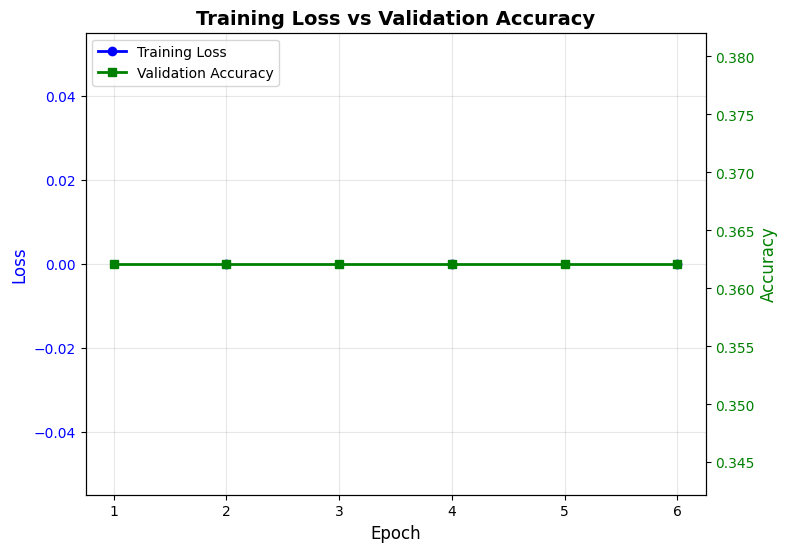

In [20]:
# Purpose: plot training loss and validation accuracy
# Visualization (example for Training Loss vs Validation Accuracy)
fig, ax = plt.subplots(figsize=(8, 6))
epochs_range = range(1, len(loss_across_epochs) + 1)
ax_twin = ax.twinx()
line1 = ax.plot(epochs_range, loss_across_epochs, 'b-o', label='Training Loss', linewidth=2)
line2 = ax_twin.plot(epochs_range, val_accuracy_across_epochs, 'g-s', label='Validation Accuracy', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12, color='b')
ax_twin.set_ylabel('Accuracy', fontsize=12, color='g')
ax.tick_params(axis='y', labelcolor='b')
ax_twin.tick_params(axis='y', labelcolor='g')
ax.grid(True, alpha=0.3)
ax.set_title('Training Loss vs Validation Accuracy', fontsize=14, fontweight='bold')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left', fontsize=10)

In [21]:
# Purpose: save and display the performance plot
plt.tight_layout()
plt.savefig('model_training_performance.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

In [22]:
# Purpose: example predictions on an in-memory test set
#make predictions (will give a probability distribution)
pred_hot = model.predict(X_test)
#now pick the most likely outcome
pred = np.argmax(pred_hot,axis=1)
y_compare = y_test.astype(int) 
#calculate accuracy
score = metrics.accuracy_score(y_compare, pred)

print("Accuracy score: {}".format(score))

print(pred_hot[:5])
print(pred)

AttributeError: 'MultiLayerPerceptron' object has no attribute 'predict'

## Evaluation

In [24]:
# Purpose: print a classification report for the validation set
# --- Step 2: Classification report ---
# Provides precision/recall/F1 per class and macro/weighted aggregates
print("=" * 80)
print("COMPREHENSIVE MODEL EVALUATION METRICS")
print("=" * 80)
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


COMPREHENSIVE MODEL EVALUATION METRICS
Classification Report:


/home/ybenj/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0       0.11      0.99      0.21    394218
           1       0.00      0.00      0.00     35369
           2       0.00      0.00      0.00    143903
           3       0.00      0.00      0.00    275174
           4       0.00      0.00      0.00    109037
           5       0.01      0.00      0.00     72270
           6       0.08      0.01      0.01    264673
           7       0.00      0.00      0.00     33186
           8       0.00      0.00      0.00    261407
           9       0.00      0.00      0.00     44807
          10       0.00      0.00      0.00    270185
          11       0.00      0.00      0.00     71460
          12       0.00      0.00      0.00    206940
          13       0.32      0.00      0.00   1248148

    accuracy                           0.11   3430777
   macro avg       0.04      0.07      0.02   3430777
weighted avg       0.14      0.11      0.03   3430777



/home/ybenj/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ybenj/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [26]:
# Purpose: compute F1 scores (macro and weighted)
# --- Step 3: F1 Scores ---
# Macro treats all classes equally; weighted accounts for class frequency
macro_f1 = f1_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
print(f"1. F1 SCORES:")
print(f"   Macro F1 (treats all classes equally): {macro_f1:.4f}")
print(f"   Weighted F1 (accounts for imbalance): {weighted_f1:.4f}")


1. F1 SCORES:
   Macro F1 (treats all classes equally): 0.0158
   Weighted F1 (accounts for imbalance): 0.0252


In [27]:
# Purpose: compute recall metrics
# --- Step 4: Recall Scores ---
# Recall measures detection rate; macro vs weighted show class imbalance impact
macro_recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
per_class_recall = recall_score(y_true_classes, y_pred_classes, average=None, zero_division=0)


In [28]:
# Purpose: compute confusion matrix
# --- Step 5: Confusion Matrix ---
# Raw counts show where predictions are confused across classes
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"3. Confusion Matrix:")
print(cm)

3. Confusion Matrix:
[[ 391342       0       0       0       0      85    2438       0       0
        0       0       0       0     353]
 [  34895       0       0       0       0       4     436       0       0
        0       0       0       0      34]
 [ 143019       0       0       0       0      12     781       0       0
        0       0       0       0      91]
 [ 273118       0       0       0       0      58    1744       0       0
        0       0       0       0     254]
 [ 108169       0       0       0       0      13     811       0       0
        0       0       0       0      44]
 [  71689       0       0       0       0       6     527       0       0
        0       0       0       0      48]
 [ 262588       0       0       0       0      39    1849       0       0
        0       0       0       0     197]
 [  32842       0       0       0       0       8     300       0       0
        0       0       0       0      36]
 [ 258977       0       0       0       0  

In [29]:
# Purpose: compute ROC-AUC with one-vs-rest for multi-class
# --- Step 6: AUROC / ROC-AUC ---
# Uses one-vs-rest for multi-class; reports macro and weighted perspectives
try:
    if num_classes == 2:
        auc = roc_auc_score(y_true_classes, y_probs[:, 1])
        print(f"4. AUROC / ROC-AUC Score:")
        print(f"   Binary AUC: {auc:.4f}")
    else:
        macro_auc = roc_auc_score(y_true_classes, y_probs, multi_class='ovr', average='macro')
        weighted_auc = roc_auc_score(y_true_classes, y_probs, multi_class='ovr', average='weighted')
        print(f"4. AUROC / ROC-AUC Scores:")
        print(f"   Macro AUC: {macro_auc:.4f}")
        print(f"   Weighted AUC: {weighted_auc:.4f}")
except Exception as e:
    print(f"AUROC calculation failed: {e}")


AUROC calculation failed: Input contains NaN.


In [30]:
# Purpose: compute overall accuracy
# --- Step 7: Overall Accuracy ---
# Single-number summary; must be interpreted alongside imbalance-aware metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"7. Overall Accuracy: {accuracy:.4f}")
print("=" * 80)

7. Overall Accuracy: 0.1149


In [31]:
# Purpose: extract loss and accuracy arrays for plotting
# Extract history arrays for visualization
if isinstance(history, list):
    loss_across_epochs = np.concatenate([h.history['loss'] for h in history])
    val_accuracy_across_epochs = np.concatenate([h.history['val_accuracy'] for h in history])
else:
    loss_across_epochs = history.history['loss']
    val_accuracy_across_epochs = history.history['val_accuracy']

# Data Analysis/Visualization

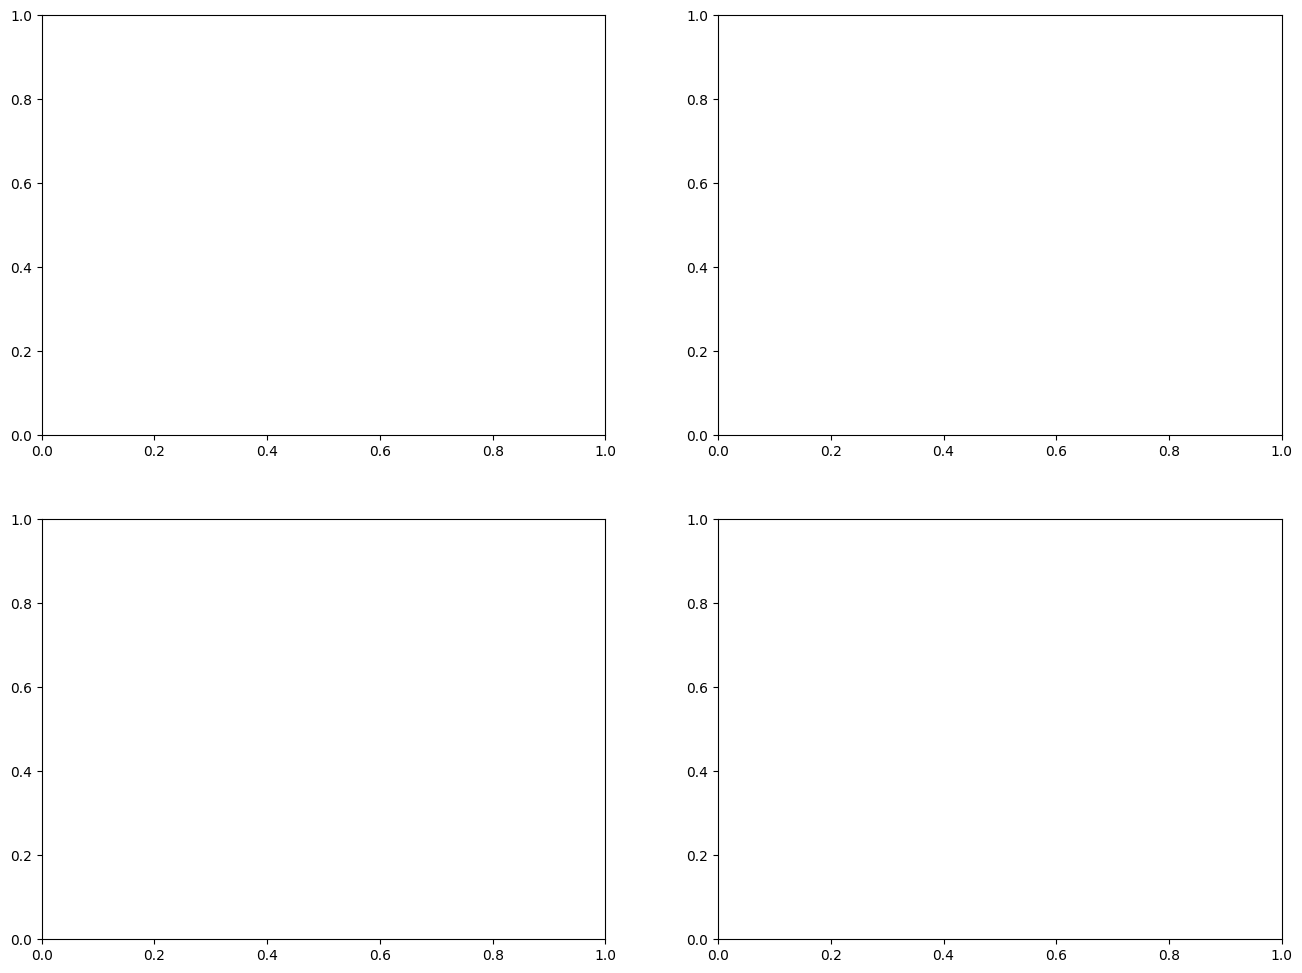

In [32]:
# Purpose: initialize a grid of evaluation plots
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


In [33]:
# Purpose: plot raw confusion matrix heatmap
# 1. Confusion Matrix Heatmap
ax1 = axes[0, 0]
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)


Text(0.5, 606.7222222222223, 'Predicted Label')

Text(0.5, 1.0, 'F1 Scores (Macro vs Weighted)')

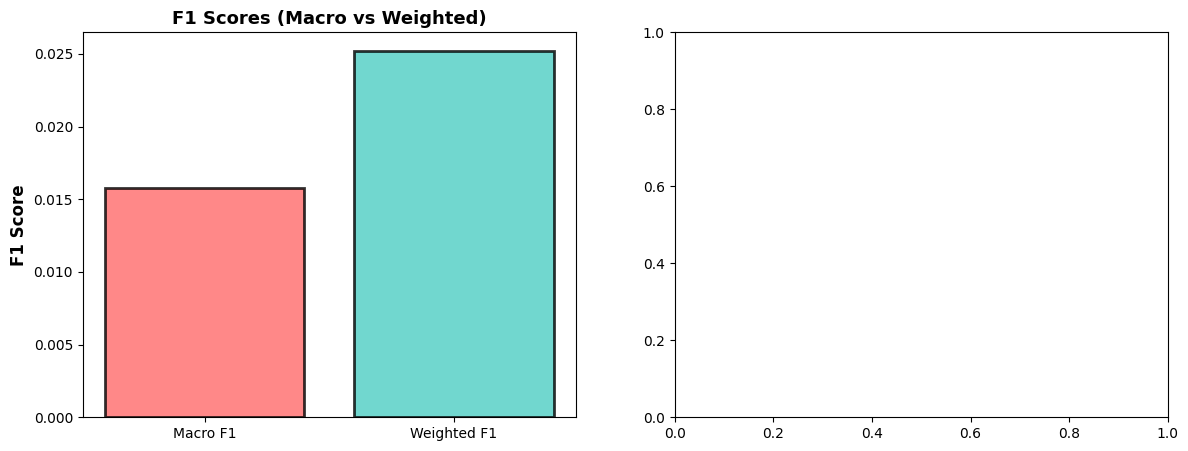

In [34]:
# Purpose: compare macro vs weighted F1 scores
# Additional metrics visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. F1 Scores Comparison
ax1 = axes[0]
metrics = ['Macro F1', 'Weighted F1']
scores = [macro_f1, weighted_f1]
colors_metrics = ['#FF6B6B', '#4ECDC4']
bars = ax1.bar(metrics, scores, color=colors_metrics, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax1.set_title('F1 Scores (Macro vs Weighted)', fontsize=13, fontweight='bold')


In [35]:
# Purpose: plot normalized confusion matrix heatmap
# 2. Normalized Confusion Matrix
ax2 = axes[0, 1]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=ax2, cbar_kws={'label': 'Recall %'})
ax2.set_title('Confusion Matrix (Normalized by True Label)', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [36]:
# Purpose: plot loss and accuracy over epochs
# 3. Training Loss and Validation Accuracy
ax3 = axes[1, 0]
epochs_range = range(1, len(loss_across_epochs) + 1)
ax3_twin = ax3.twinx()
line1 = ax3.plot(epochs_range, loss_across_epochs, 'b-o', label='Training Loss', linewidth=2, markersize=6)
line2 = ax3_twin.plot(epochs_range, val_accuracy_across_epochs, 'g-s', label='Validation Accuracy', linewidth=2, markersize=6)
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Loss', color='b', fontsize=12)
ax3_twin.set_ylabel('Validation Accuracy', color='g', fontsize=12)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [37]:
# Purpose: merge legends for twin-axis plot
# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='upper left', fontsize=10)


NameError: name 'ax3' is not defined

In [38]:
# Purpose: plot per-class recall with macro baseline
# 4. Per-Class Recall Bar Chart
ax4 = axes[1, 1]
class_names = [f'Class {i}' for i in range(len(per_class_recall))]
colors = ['green' if r > 0.5 else 'orange' if r > 0.3 else 'red' for r in per_class_recall]
bars = ax4.bar(class_names, per_class_recall, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.axhline(y=macro_recall, color='r', linestyle='--', linewidth=2, label=f'Macro Recall = {macro_recall:.2f}')
ax4.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax4.set_title('Per-Class Recall', fontsize=13, fontweight='bold')
ax4.legend()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [39]:
# Purpose: annotate bars and save evaluation plot
# Add value labels on bars
for bar, recall in zip(bars, per_class_recall):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{recall:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


NameError: name 'ax4' is not defined

## ROC Curves and Per-Class Metrics
- One-vs-rest ROC curves summarize how well the model separates each class; micro-average checks overall ranking quality.
- The metrics heatmap condenses precision/recall/F1 per class (top 10 shown) to spot which classes drive performance up or down.
- Scores are clipped to [0,1] with consistent color scaling to make weak classes visually obvious.

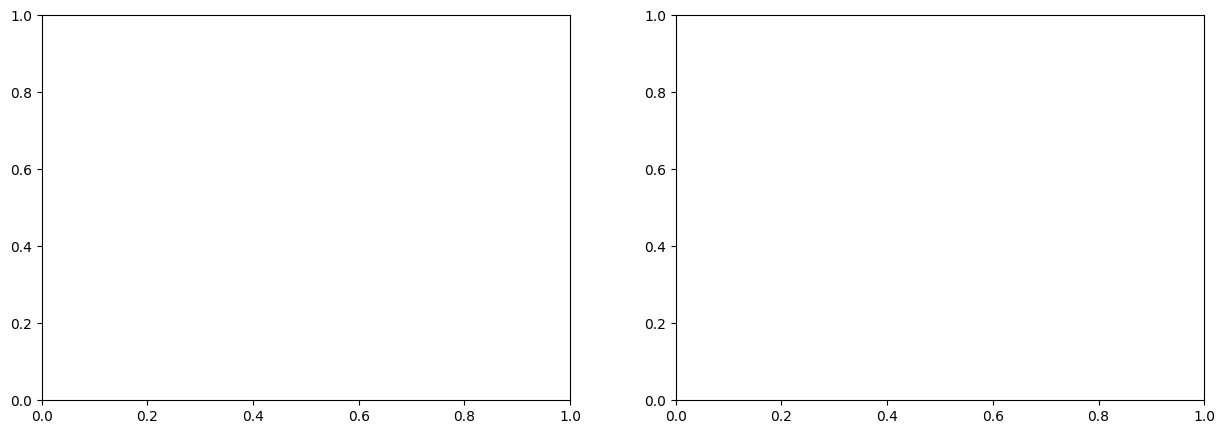

In [40]:
# Purpose: set up ROC curves and metrics heatmap panels
# ROC-AUC Curves (One-vs-Rest for multi-class)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))


In [41]:
# Purpose: compute and plot one-vs-rest ROC curves
# 1. ROC Curve (One-vs-Rest)
ax1 = axes[0]
if num_classes > 2:
    # Multi-class: compute one-vs-rest ROC per class (limit to top 5 for readability)
    all_true_bin = label_binarize(all_true, classes=range(num_classes))
    
    colors = plt.cm.Set3(np.linspace(0, 1, num_classes))
    auc_scores = []
    
    for i in range(min(num_classes, 5)):  # Limit to 5 classes for clarity
        fpr, tpr, _ = roc_curve(all_true_bin[:, i], all_probs[:, i])
        auc_i = auc(fpr, tpr)
        auc_scores.append(auc_i)
        ax1.plot(fpr, tpr, label=f'Class {i} (AUC={auc_i:.2f})', color=colors[i])

    ax1.plot([0, 1], [0, 1], 'k--', label='Random')
    ax1.set_title('ROC Curves (Top 5 Classes)', fontsize=13, fontweight='bold')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend(fontsize=9)
else:
    # Binary case
    fpr, tpr, _ = roc_curve(all_true, all_probs[:, 1])
    auc_score = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f'AUC={auc_score:.2f}')
    ax1.plot([0, 1], [0, 1], 'k--', label='Random')
    ax1.set_title('ROC Curve', fontsize=13, fontweight='bold')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend(fontsize=9)


ValueError: Input contains NaN.

In [42]:
# Purpose: assemble per-class precision/recall/F1 heatmap
# 2. Per-Class Metrics Heatmap
ax2 = axes[1]
precision, recall, f1, support = precision_recall_fscore_support(all_true, all_preds, 
                                                                   average=None, zero_division=0)

metrics_data = np.array([precision, recall, f1]).T
im = ax2.imshow(metrics_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)


In [43]:
# Purpose: label heatmap axes and title
# Set ticks and labels
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Precision', 'Recall', 'F1'], fontsize=11, fontweight='bold')
ax2.set_yticks(range(min(len(precision), 10)))
ax2.set_yticklabels([f'Class {i}' for i in range(min(len(precision), 10))], fontsize=10)
ax2.set_title('Per-Class Metrics Heatmap (Top 10 Classes)', fontsize=13, fontweight='bold')


Text(0.5, 1.0, 'Per-Class Metrics Heatmap (Top 10 Classes)')

In [44]:
# Purpose: annotate heatmap and finalize figure
# Add text annotations for top-10 classes only to keep plot readable
for i in range(min(len(precision), 10)):
    for j in range(3):
        text = ax2.text(j, i, f'{metrics_data[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Score', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


/tmp/ipykernel_152940/303284227.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 1500x500 with 3 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=ax2)


<Figure size 640x480 with 0 Axes>